In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import simps
from IPython.display import clear_output
import glob
import pybedtools as pbt

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

In [60]:
def extract_seq(bed_file):
    chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
    control_chrom_wise_intervals = {}
    chrom_wise_intervals = {}
    for chrom in chroms:
        chrom_wise_intervals[chrom] = []
        control_chrom_wise_intervals[chrom] = []
    control_bed = []
    with open (bed_file) as h:
        for l in h:
            c = l.split('\t')
            if c[0] in chroms:
                chrom_wise_intervals[c[0]].append((int(c[1]), int(c[2])))
                len_int = int(c[2]) - int(c[1])
                start = int(c[1])-500-len_int
                end = int(c[1])-500
                control_chrom_wise_intervals[c[0]].append((start, end))
                control_bed.append('\t'.join([chrom, str(start), str(end)]))
    
    sequences = []
    control_sequences = []
    fasta_base_dir ='/home/parashar/scratch/hg19_resource/chromosomes'
    nuc_map = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'N': 'N'}
    for chrom in chroms:
        print (chrom)
        chrom_seq = "".join([x.rstrip('\n') for x in
               open("%s/%s.fa" % (fasta_base_dir, chrom)).readlines()[1:]]).upper()
        for span in chrom_wise_intervals[chrom]:
            sequences.append(chrom_seq[span[0]:span[1]])
        for span in control_chrom_wise_intervals[chrom]:
            control_sequences.append(chrom_seq[span[0]:span[1]])
        clear_output()
    with open('../data/chem_seq_g4/peaks.seq', 'w') as OUT:
        OUT.write("\n".join(sequences))
    with open('../data/chem_seq_g4/control_peaks.seq', 'w') as OUT:
        OUT.write("\n".join(control_sequences))
    with open('../data/chem_seq_g4/control_peaks.bed', 'w') as OUT:
        OUT.write("\n".join(control_bed))

extract_seq('../data/chem_seq_g4/common_peaks.bed')

In [61]:
! Rscript G4Hunter.r ../data/chem_seq_g4/peaks.seq ../data/chem_seq_g4/peaks_hunter_scores.txt
! Rscript G4Hunter.r ../data/chem_seq_g4/control_peaks.seq ../data/chem_seq_g4/control_peaks_hunter_scores.txt
clear_output()

In [2]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

peaks_bed = pbt.BedTool('../data/chem_seq_g4/common_peaks.bed')
control_bed = pbt.BedTool('../data/chem_seq_g4/control_peaks.bed')

scores = []
control_scores = []
for chrom in chroms:
    pos_score = np.load('../data/sniprq_scores/%s_%s.npy' % (chrom, 'positive'), mmap_mode='r')
    neg_score = np.load('../data/sniprq_scores/%s_%s.npy' % (chrom, 'negative'), mmap_mode='r')
    for i,j in zip(peaks_bed, control_bed):
        ci = str(i).rstrip('\n').split('\t')
        cj = str(j).rstrip('\n').split('\t')
        if ci[0] == chrom:
            scores.append(pos_score[int(ci[1]):int(ci[2])] + neg_score[int(ci[1]):int(ci[2])])
            control_scores.append(pos_score[int(cj[1]):int(cj[2])] + neg_score[int(cj[1]):int(cj[2])])
np.save('../data/chem_seq_g4/peaks_snipr_scores', np.array(scores))
np.save('../data/chem_seq_g4/peaks_snipr_control_scores', np.array(control_scores))

In [3]:
peak_snipr = np.load('../data/chem_seq_g4/peaks_snipr_scores.npy')
control_snipr = np.load('../data/chem_seq_g4/peaks_snipr_control_scores.npy')

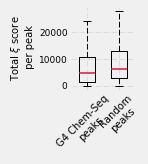

In [9]:
peak_snipr = np.load('../data/chem_seq_g4/peaks_snipr_scores.npy')
control_snipr = np.load('../data/chem_seq_g4/peaks_snipr_control_scores.npy')

fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([[np.sum(x) for x in peak_snipr], [np.sum(x) for x in control_snipr]],
           sym='', widths=[0.5, 0.5], boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
#ax.set_ylim((-0.05, 0.7))
ax.set_ylabel(r'Total $\xi$ score'+'\n per peak', fontsize=10)
clean_axis(ax)
ax.set_xticklabels(['G4 Chem-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)

plt.tight_layout()
#plt.savefig('../images/g4_chem_seq_exp_scores.png', dpi=300, transparent=True, edgecolor='none')
#plt.savefig('../images/g4_chem_seq_exp_scores.svg', transparent=True, edgecolor='none')
plt.show()
#mannwhitneyu([sum(x) for x in peak_exp], [sum(x) for x in random_exp])

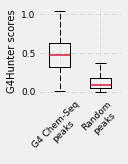

In [5]:
def load_hunter(fn):
    s = []
    with open(fn) as h:
        next(h)
        for l in h:
            c = l.rstrip('\n').split('\t')
            s.append(abs(float(c[1])))
    s = np.array(s)
    return s

peak_hunter_scores = load_hunter('../data/chem_seq_g4/peaks_hunter_scores.txt')
random_peaks_hunter_scores = load_hunter('../data/chem_seq_g4/control_peaks_hunter_scores.txt')

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([peak_hunter_scores, random_peaks_hunter_scores], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel('G4Hunter scores', fontsize=10)
ax.set_xticklabels(['G4 Chem-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/g4_chem_seq_hunter_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chem_seq_hunter_scores.svg', transparent=True, edgecolor='none')
plt.show()